In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns

size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,4),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

In [2]:
# Read data from csv
DATA_PATH = '../data/games_info_bigger.csv'
df = pd.read_csv(DATA_PATH)

In [3]:
df.head()

,Title,Release date,Platform,Other platforms,Publisher,Developer,Genres,Rating,Number of players,Metascore,Number of critic reviews,User Score,Number of user reviews
0,Portal Companion Collection,"Jun 28, 2022",Switch,NaN,Valve Software,Valve Software,"Miscellaneous,Compilation",NaN,NaN,96.0,9,8.0,101
1,Elden Ring,"Feb 25, 2022",Xbox Series X,"PC,PlayStation 4,PlayStation 5,Xbox One",Bandai Namco Games,From Software,"Role-Playing,Action RPG",M,Up to 4,96.0,19,7.7,2509
2,Elden Ring,"Feb 25, 2022",PlayStation 5,"PC,PlayStation 4,Xbox One,Xbox Series X",Bandai Namco Games,From Software,"Role-Playing,Action RPG",M,Up to 4,96.0,84,7.8,10647
3,Persona 5 Royal,"Oct 21, 2022",PC,"PlayStation 4,PlayStation 5,Switch,Xbox One,Xb...",Sega,Atlus,"Role-Playing,Japanese-Style",M,No Online Multiplayer,95.0,13,8.7,197
4,Persona 5 Royal,"Oct 21, 2022",Xbox Series X,"PC,PlayStation 4,PlayStation 5,Switch,Xbox One",Sega,Atlus,"Role-Playing,Japanese-Style",M,No Online Multiplayer,94.0,9,8.5,105


## Đặt bài toán cần giải quyết

#### Bài toán nhóm đặt ra là Sử dụng các Regression model để dự đoán giá trị User score

## Tiền xử lý

Do cột `Publisher` có khá nhiều công ty nên mình chỉ lấy 10 công ty có số lượng nhiều nhất (thường là những công ty nổi tiếng)

In [4]:
df["Publisher"].value_counts().head(10)

Nintendo                  158
Electronic Arts           132
Sega                      114
EA Sports                 107
Ubisoft                    99
SCEA                       97
Capcom                     92
Microsoft Game Studios     89
Activision                 88
Square Enix                69
Name: Publisher, dtype: int64

Thực hiện <b>One-Hot encoding</b> với cột `Publisher`, các công ty không nằm trong 10 công ty lớn thì bỏ vào cột `Other companies`

In [5]:
big_companies = ['Nintendo', 'Electronic Arts', 'Sega', 'EA Sports', 'Ubisoft', 'SCEA', 'Capcom', 'Microsoft Game Studios', 'Activision', 'Square Enix']

def handle_publisher(x):
    if x not in big_companies:
        return 'Other companies'
    return x


df['Publisher'].fillna('Other companies')
df['Publisher'] = df['Publisher'].astype('str').apply(lambda x: handle_publisher(x))

one_hot = pd.get_dummies(df["Publisher"])
df = pd.concat([df, one_hot], axis=1, join='inner')

Tiếp tục thực hiện <b>One-Hot encoding</b> với cột `Platform`

In [6]:
one_hot = pd.get_dummies(df["Platform"])
df = pd.concat([df, one_hot], axis=1, join='inner')

Loại bỏ cột `Release date`, `Platform`, `Publisher`, `Title`, `Other platforms`, `Metascore`, `Number of critic reviews`, `Number of user reviews`, `Developer`

In [7]:
df = df.drop(columns=[
    'Release date', 
    'Platform',
    'Publisher', 
    'Title', 
    'Other platforms', 
    'Metascore', 
    'Number of critic reviews', 
    'Number of user reviews', 
    'Developer']
)

Thay thế các giá trị nan trong cột `Rating` bằng giá trị xuất hiện nhiều nhất trong cột

Chuyển các giá trị trong cột `Rating` từ string sang integer như trong phần tiền xử lý dữ liệu

In [8]:
df['Rating'] = df['Rating'].fillna(df['Rating'].mode()[0])
def handle_rating(x):
    if x == 'E':
        return str(3)
    if x == 'K-A':
        return str(6)
    if x == 'E10+':
        return str(10)
    if x == 'T':
        return str(13)
    if x == 'M':
        return str(17)
    if x == 'AO':
        return str(18)

df['Rating'] = df['Rating'].astype('str').apply(lambda x: handle_rating(x)).astype(int)

* Cột `Genres` mở rộng thành nhiều cột khác, mỗi genre là một cột và thể hiện bằng giá trị int.
* Cột `Number of players` lấy giá trị số lượng người chơi cao nhất trong chuỗi string; riêng 'Massively Multiplayer', 'Online Multiplayer' thay bằng giá trị 100 sau đó thay thế các giá trị nan trong cột bằng giá trị xuất hiện nhiều nhất trong cột.
* Bỏ cột `Genres`.

In [9]:
# Xử lý cột Genres
genres_df = df['Genres'].str.split(',', expand=True).apply(pd.value_counts, axis=1).fillna(0)
for col in genres_df:
    genres_df[col] = genres_df[col].astype(int)

df = pd.concat([df, genres_df], axis=1, join='inner')

# Xử lý cột Number of players
def handle_n_players(x):
    if x in ['Massively Multiplayer', 'Online Multiplayer']:
        return str(100)

    tokens = x.replace('+', ' ').replace('-', ' ').split()
    max_player = 1
    for token in tokens:
        if token.isdigit():
            max_player = max(max_player, int(token))
    return str(max_player)

df['Number of players'] = df['Number of players'].astype('str').apply(lambda x: handle_n_players(x)).astype(int)
df['Number of players'] = df['Number of players'].fillna(df['Number of players'].mode()[0])

# Loại bỏ cột Genres
df = df.drop(columns=['Genres'])

Dữ liệu sau khi tiền xử lý

In [10]:
df.head(5)

,Rating,Number of players,User Score,Activision,Capcom,EA Sports,Electronic Arts,Microsoft Game Studios,Nintendo,Other companies,...,Tycoon,Vehicle,Vertical,Virtual,Virtual Life,Visual Novel,WWII,Wargame,Western-Style,Wrestling
0,13,1,8.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,17,4,7.7,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,17,4,7.8,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,17,1,8.7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17,1,8.5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Phân chia dữ liệu thành 2 set: `training set` (75%) và `testing set` (25%)

In [11]:
x = df.drop(['User Score'] , axis = 1).values
y= df['User Score'].values
x_train , x_test , y_train , y_test = train_test_split(x,y , test_size= 0.25 , random_state=42)

Scale dữ liệu sử dụng <b>RobustScaler</b>

In [12]:
ro_scaler = RobustScaler()
x_train = ro_scaler.fit_transform(x_train)
x_test = ro_scaler.fit_transform(x_test)
r, c = x_train.shape
r2 ,c2 = x_test.shape
print (f"x_train = {r} and y_train = {y_train.shape} ")
print (f"x_test = {r2} and y_test = {y_test.shape} ")

x_train = 1719 and y_train = (1719,) 
x_test = 573 and y_test = (573,) 


## Mô hình hoá dữ liệu

Nhóm sử dụng 3 regression model: `K Neighbors Regressor`, `SVR` , `Decision Tree Regressor` để phân loại <b>User score</b>

Sử dụng `GridSearchCV` để xác định các hyperparameter cho model

#### 1. KNN

In [13]:
knn_params = {"n_neighbors": np.arange(2,30,1)}

knn_model = KNeighborsRegressor()

knn_cv_model = GridSearchCV(knn_model, knn_params, cv = 10).fit(x_train, y_train)

In [14]:
knn_cv_model.best_params_

{'n_neighbors': 14}

In [15]:
knn_tuned = KNeighborsRegressor(**knn_cv_model.best_params_).fit(x_train, y_train)

Tính toán các thông số đánh giá `MSE`, `RMSE`, `R square`

In [16]:
# sklearn regression module
y_pred = knn_tuned.predict(x_test)

#Evaluvation: MSE
J_mse = mean_squared_error(y_test, y_pred)

#Evaluvation: RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

# R_square
R_square = knn_tuned.score(x_test, y_test)

print('The Mean Square Error(MSE) or J(theta) is: ', J_mse)
print('The Root Mean Square Error(RMSE) is: ', rmse)
print('R square obtain for scikit learn library is :', R_square)

The Mean Square Error(MSE) or J(theta) is:  0.7061827296363572
The Root Mean Square Error(RMSE) is:  0.8403467912929502
R square obtain for scikit learn library is : 0.17066221740623122


#### 2. SVR

In [17]:
svr_model = SVR() 

svr_params = {"C": [0.01, 0.001, 0.2, 0.1, 0.5, 0.8, 0.9, 1, 10, 100, 500, 1000]}

svr_cv_model = GridSearchCV(svr_model, svr_params, cv = 10, n_jobs = -1, verbose = 2).fit(x_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [18]:
svr_cv_model.best_params_

{'C': 10}

In [19]:
svr_tuned = SVR(**svr_cv_model.best_params_).fit(x_train, y_train)

Tính toán các thông số đánh giá `MSE`, `RMSE`, `R square`

In [20]:
# sklearn regression module
y_pred = svr_tuned.predict(x_test)

#Evaluvation: MSE
J_mse = mean_squared_error(y_test, y_pred)

#Evaluvation: RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

# R_square
R_square = svr_tuned.score(x_test, y_test)

print('The Mean Square Error(MSE) or J(theta) is: ', J_mse)
print('The Root Mean Square Error(RMSE) is: ', rmse)
print('R square obtain for scikit learn library is :', R_square)

The Mean Square Error(MSE) or J(theta) is:  0.6469292756311158
The Root Mean Square Error(RMSE) is:  0.8043191379241923
R square obtain for scikit learn library is : 0.24024920402233496


#### 3. CART

In [27]:
cart_model = DecisionTreeRegressor()

cart_params = {"max_depth": [2, 3, 4, 5, 10, 20, 100, 1000],
              "min_samples_split": [2, 5, 10, 30, 50, 60, 70, 80, 100]}

cart_cv_model = GridSearchCV(cart_model, cart_params, cv = 10, n_jobs = -1, verbose = 2).fit(x_train, y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


In [28]:
cart_cv_model.best_params_

{'max_depth': 4, 'min_samples_split': 80}

In [29]:
cart_tuned = DecisionTreeRegressor(**cart_cv_model.best_params_).fit(x_train, y_train)

Tính toán các thông số đánh giá `MSE`, `RMSE`, `R square`

In [30]:
# sklearn regression module
y_pred = cart_tuned.predict(x_test)

#Evaluvation: MSE
J_mse = mean_squared_error(y_test, y_pred)

#Evaluvation: RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

# R_square
R_square = cart_tuned.score(x_test, y_test)

print('The Mean Square Error(MSE) or J(theta) is: ', J_mse)
print('The Root Mean Square Error(RMSE) is: ', rmse)
print('R square obtain for scikit learn library is :', R_square)

The Mean Square Error(MSE) or J(theta) is:  0.7379048901386993
The Root Mean Square Error(RMSE) is:  0.8590139056724864
R square obtain for scikit learn library is : 0.13340785653614418


## Đánh giá các mô hình

#### So sánh `RMSE` giữa các mô hình

In [31]:
models = [
    knn_tuned,
    svr_tuned,
    cart_tuned,
]


for model in models:
    isimler = model.__class__.__name__
    y_pred = model.predict(x_test)
    error = mean_squared_error(y_test, y_pred, squared=False)
    print("-"*28)
    print(isimler + ":" )
    print("Error: " + str(error))

----------------------------
KNeighborsRegressor:
Error: 0.8403467912929502
----------------------------
SVR:
Error: 0.8043191379241923
----------------------------
DecisionTreeRegressor:
Error: 0.8590139056724864


#### Vẽ biểu đồ thể hiện độ lỗi giữa các mô hình

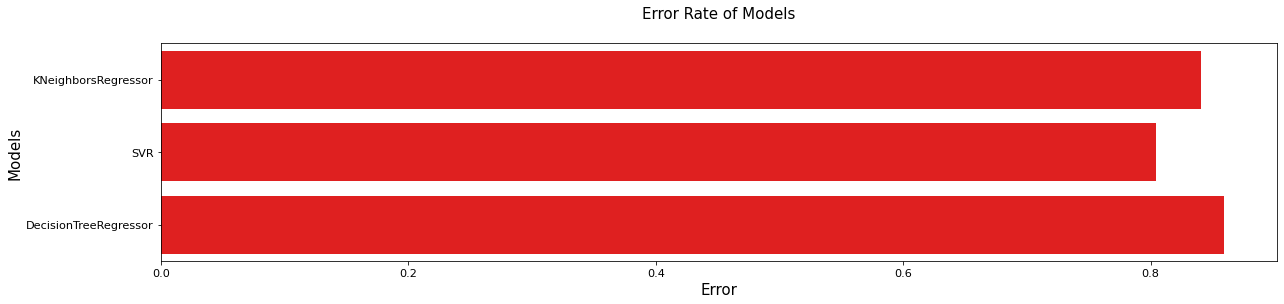

In [32]:
sonuc = []

sonuclar = pd.DataFrame(columns= ["Models","Error"])

for model in models:
    isimler = model.__class__.__name__
    y_pred = model.predict(x_test)
    hata = np.sqrt(mean_squared_error(y_test, y_pred))    
    sonuc = pd.DataFrame([[isimler, hata]], columns= ["Models","Error"])
    sonuclar = pd.concat([sonuclar, sonuc])
    
    
sns.barplot(x= 'Error', y = 'Models', data=sonuclar, color="r")
plt.xlabel('Error')
plt.title('Error Rate of Models');  